### Get Data and Visualize

In [1]:
import pandas as pd

df = pd.read_csv('Data_Households_SmartPV.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

weekday_df = df[df['Timestamp'].dt.dayofweek < 5]
weekday_avg = weekday_df.groupby([weekday_df['Timestamp'].dt.hour, weekday_df['Timestamp'].dt.minute]).mean()
timestamps = pd.date_range(start='2016-06-15 00:00:00', end='2016-06-15 23:30:00', freq='30min')
weekday_avg['Timestamp'] = timestamps
weekday_avg.set_index('Timestamp', inplace=True)
weekday_avg = weekday_avg / 1000  # Convert to kWh
weekday_avg.head()




,NM_meter,Import,Export,PV_meter,Production,Consumption,NetLoad
Timestamp,,,,,,,
2016-06-15 00:00:00,0.614941,0.845336,0.0,0.586632,0.0,0.845336,0.845336
2016-06-15 00:30:00,0.614931,0.789306,0.0,0.586633,0.0,0.789306,0.789306
2016-06-15 01:00:00,0.614941,0.747229,0.0,0.586632,0.0,0.747229,0.747229
2016-06-15 01:30:00,0.614931,0.720732,0.0,0.586633,0.0,0.720732,0.720732
2016-06-15 02:00:00,0.614941,0.688052,0.0,0.586632,0.0,0.688052,0.688052


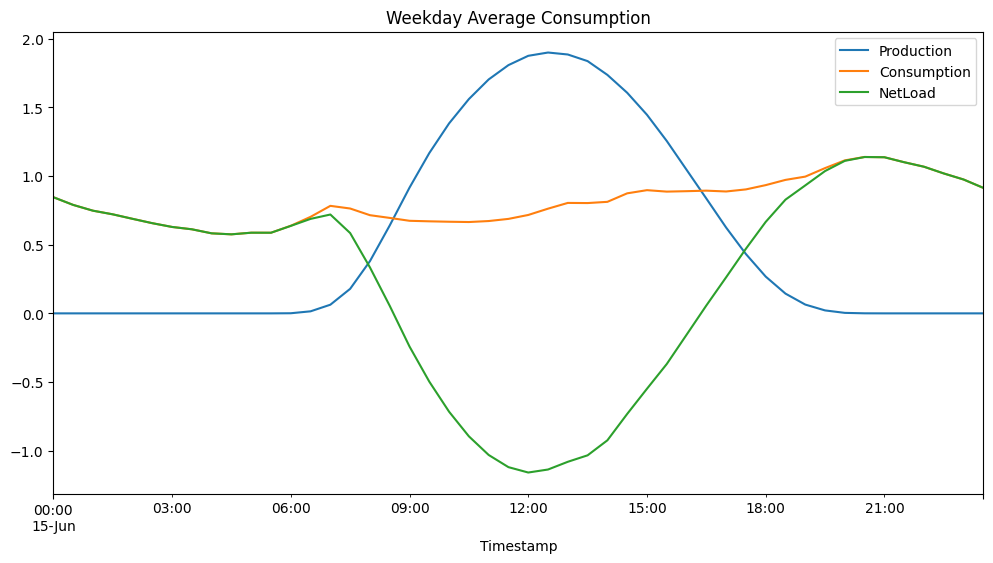

In [2]:
import matplotlib.pyplot as plt
_ = weekday_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Weekday Average Consumption', figsize=(12, 6))

### Battery Control

This optimization is the basic scenario of controlling the battery for a day. Primarily, this is meant to test functionality of the optimization before scaling to more complicated pricing schemes. 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.04866454353377
            Iterations: 44
            Function evaluations: 2247
            Gradient evaluations: 44


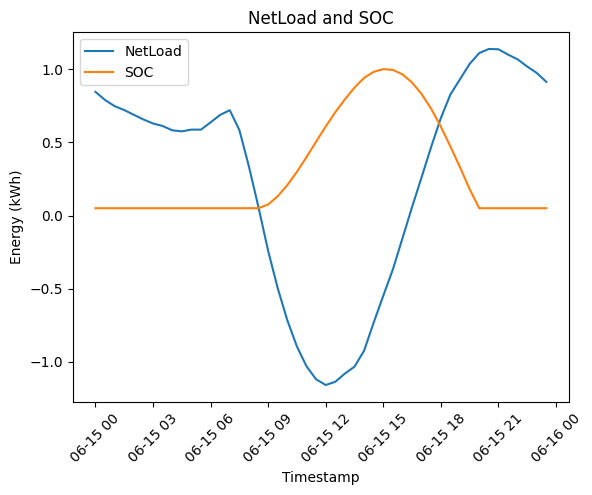

In [9]:
from charge_optimizer import ChargeOptimizer
import numpy as np

BATT_PRICE_PER_KWH = 127  # Euros per kWh (127 is what was found online)
max_charge_rate = 0.5  # Max charge rate in % per hour
max_discharge_rate = 0.5  # Max discharge rate in % per hour
soc_min = 0.05  # Maximum Depth of Discharge 95%
soc_max = 1.00  # Maximum State of Charge 100%; can play around with to protect battery
sqrt_eff = 0.98  # round trip Efficiency of the battery
self_discharge = 0.05  # 5% self discharge per day; totally made up
batt_life = 10 # years; totally made up
import_tariff = np.full(24, 0.37) # Single price tariff; 0.37 Euros per kWh


charge_optimizer = ChargeOptimizer(
    pred_net_load=weekday_avg['NetLoad'],
    duration=1,
    import_tariff=import_tariff,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5, # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
    batt_capacity=8,  # 13.5 kWh
)

charge_optimizer.local_optimize(method='SLSQP', tol=1e-6)
charge_optimizer.plot_results(weekday_avg.index)

In [5]:
charge_optimizer.result.x

array([ 0.00255102,  0.00255102,  0.00255102,  0.00255102,  0.00255102,
        0.00255102,  0.00255102,  0.00255102,  0.00255102,  0.00255102,
        0.00255102,  0.00255102,  0.00255102,  0.00255102,  0.00255102,
        0.00255102,  0.00255102,  0.00255102,  0.02413543,  0.04968568,
        0.07157303,  0.08947048,  0.10304018,  0.11190969,  0.11581525,
        0.11362454,  0.10800468,  0.10329502,  0.0923777 ,  0.07319358,
        0.05486605,  0.03685702,  0.01559769, -0.00571889, -0.02624014,
       -0.04702404, -0.06654517, -0.08275002, -0.09311118, -0.10355396,
       -0.11098243, -0.00292598,  0.00255102,  0.00255102,  0.00255102,
        0.00255102,  0.00255102,  0.00255102])

# Optimization of Battery Size for Net Savings

This optimization accounts for the price of batteries and finds the optimal battery size to save consumers money (for the specified sample of 3kW systems). This exists for both TOU tariffs and single-price tariffs. 

Information: https://about.bnef.com/blog/lithium-ion-battery-pack-prices-hit-record-low-of-139-kwh/
https://natec.com/wp-content/uploads/2020/12/6020-0205-Datasheet-LG-Chem-RESU-10H-High-Voltage-400V-type-C-for-SMA.pdf

## Single Price Tariff Optimization

Although Cyprus uses Net-Metering, this study examines export energy that does not recieve remuneration

### Local Minimization

This code examines local minimization of the basic problem using SciPy minimize with SLSQP method.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.259092378912946
            Iterations: 140
            Function evaluations: 7287
            Gradient evaluations: 140
Battery Size: 8.493252828425808 kWh
Objective Function Final Value: 7.259092378912946


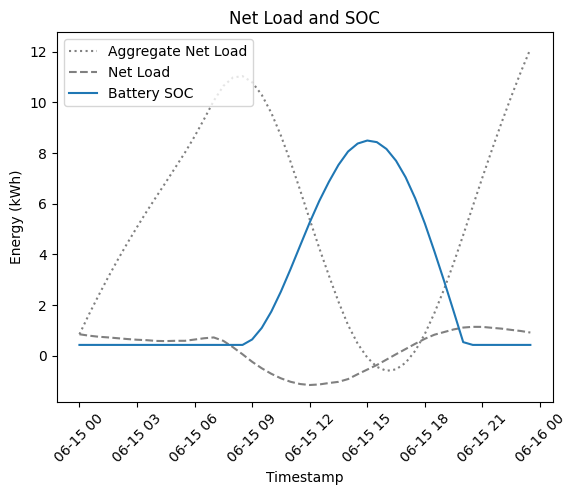

In [9]:
from price_optimizer import PriceOptimizer

price_optimizer = PriceOptimizer(
    pred_net_load=weekday_avg["NetLoad"],
    duration=1,
    batt_price_per_kWh=BATT_PRICE_PER_KWH,
    import_tariff=import_tariff,
    batt_life=batt_life,
    soc_min=soc_min,
    soc_max=soc_max,
    charge_efficiency=sqrt_eff,
    discharge_efficiency=sqrt_eff,
    self_dis=self_discharge,
    timestep_size=0.5,  # half an hour
    max_charge_rate=max_charge_rate,
    max_discharge_rate=max_discharge_rate,
)

price_optimizer.local_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)


### Global Minimization

This code examines the same, simple problem above. However, here we use global minimization with differential evolution. The results are somewhat surprising upon first examination; global minimization should outperform local minimization if correctly done. However, given that the initial guess provided to local minimization makes strong inuitive sense given the problem at hand, we can imagine that the local minimization is better equipped to more quickly hone in on the optimal spread. However, future work could be done to refine the globalization model (such as different strategies and searching time) that could/should result in results as good as the local minimization.  

Battery Size: 2.1128210528549722 kWh
Objective Function Final Value: 8.768694120734727


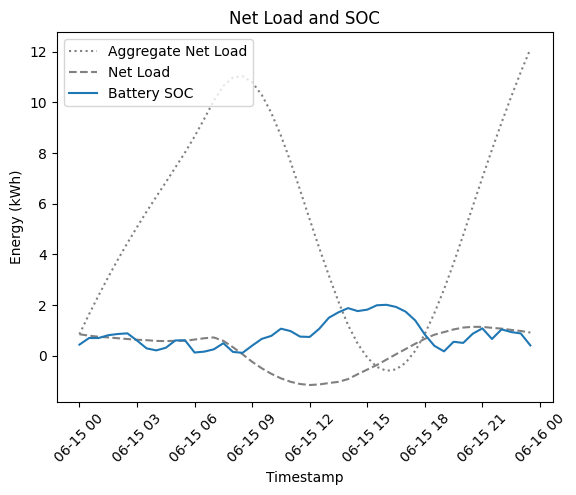

In [5]:
price_optimizer.batt_ub = 10 # Close bounds for global optimization
price_optimizer.batt_lb = 2
price_optimizer.global_optimize()

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)

### Bi-Level Optimization

This optimization method uses a two-tiered approach. The first, or "inner", optimization works to minimize an objective function pertaining to only the charge control. The outer optimization takes the inner optimization as an objective function and works to optimize the capacity of the battery for cost-savings. This approach should have to advantages: The first is to simply a complex optimization problem into two very simple problems. Both charge control and battery size are simple problems by themselves – as such, this optimization should take advantage of the easy nature of the decomposed problem. The second is to place an emphasis on battery capacity. In the above optimizations, the battery size is just another input variable like any of the timepoints. In larger and larger duration optimizations this will become problematic because battery size is an extremely important input. Yet to have it be one of tens of thousands of inputs will overcomplicate the model; thus, this approach more naturally addresses the structure of the problem. 

In the first cell we visualize this phenomenon by plotting the output of the charge minimization with respect to x. This allows us to visualize how the minimization works. 

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59


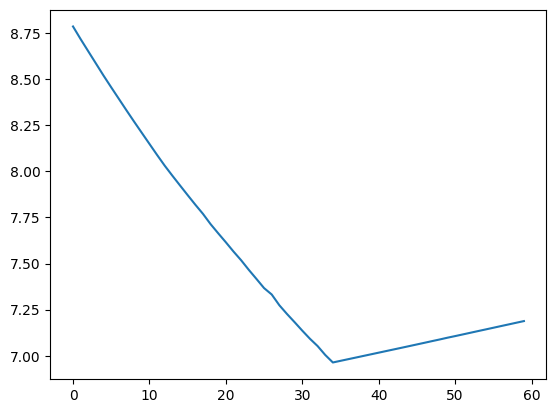

In [9]:

price_optimizer.batt_ub = 100 # Open bounds for other optimization
price_optimizer.batt_lb = 0

objective_vals = []

for i in range(0, 60):
    charge_optimizer.set_batt_capacity(i / 4.0)
    charge_optimizer.local_optimize(method='SLSQP', disp=False, tol=1e-6)
    objective_vals.append(float(charge_optimizer.result.fun))
    print(f'Iteration: {i}')

plt.plot(range(0, 60), objective_vals)


/Users/alextseng/MacDocuments/foss-optimization/price_optimizer.py:112: RuntimeWarning: Method BFGS cannot handle bounds.
  result = spo.minimize(


Iteration of battery capacity: 2.0. Objective value: 8.33784147116698
Iteration of battery capacity: 4.0. Objective value: 7.957367138181565
Iteration of battery capacity: 2.1902371664927074. Objective value: 8.298682469343241
Iteration of battery capacity: 4.190237166492707. Objective value: 7.924147140855498
Iteration of battery capacity: 2.951185832463537. Objective value: 8.143779381918291
Iteration of battery capacity: 4.951185832463537. Objective value: 7.796075326427307
Iteration of battery capacity: 5.994980496346855. Objective value: 7.625798194989664
Iteration of battery capacity: 7.994980496346855. Objective value: 7.327594022368837
Iteration of battery capacity: 15.641575346024174. Objective value: 7.764583140803746
Iteration of battery capacity: 17.641575346024176. Objective value: 7.9067009870456335
Iteration of battery capacity: 9.345225970118156. Objective value: 7.318971684119544
Iteration of battery capacity: 11.345225970118156. Objective value: 7.459804892263853
Iter

/Users/alextseng/MacDocuments/foss-optimization/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


Battery Size: 8.270543405913974 kWh
Objective Function Final Value: 7.000961120040785


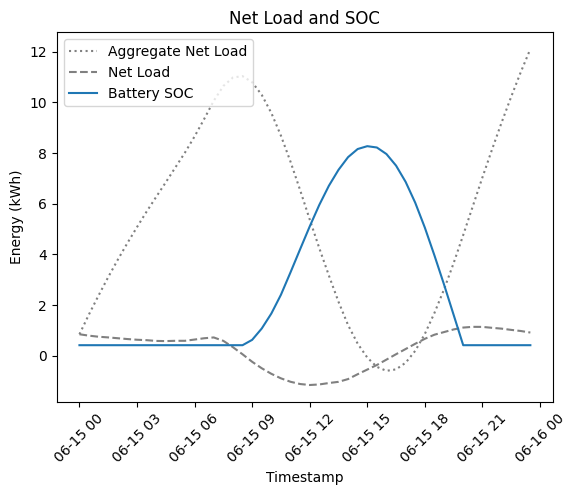

In [10]:
price_optimizer.bilevel_optimize(method='BFGS')

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(weekday_avg.index)

## Average Week Optimization

Up to this point, we have explored an average day. Although this allows us to visually and intuitively check the correctness of optimization, it is also fairly trivial and provides little meaningful information. Here we scale the optimization to an average week, month, and year. 

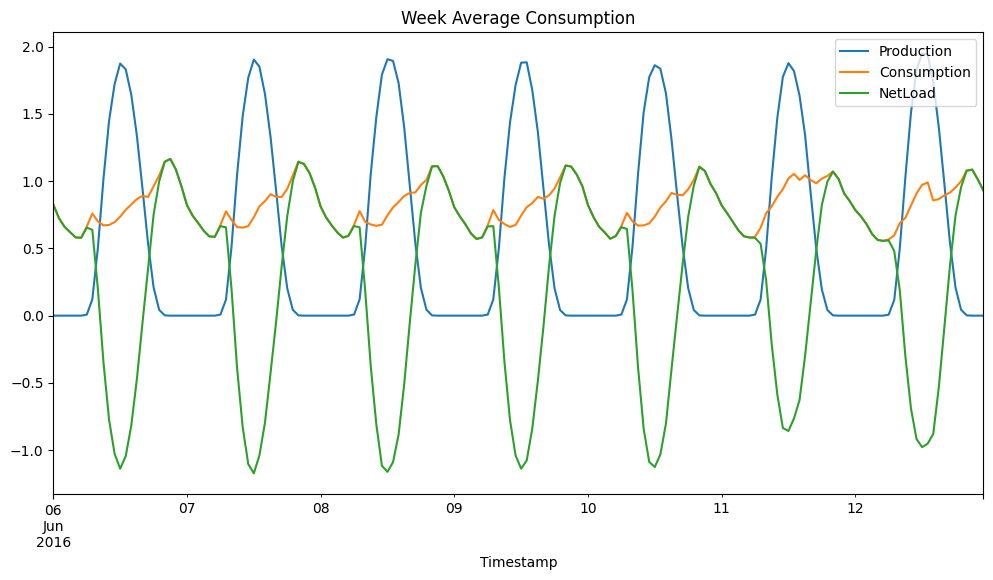

In [10]:
week_avg = df.groupby([df['Timestamp'].dt.day_of_week, df['Timestamp'].dt.hour]).mean()
timestamps = pd.date_range(start='2016-06-06 00:00:00', end='2016-06-12 23:30:00', freq='1h')
week_avg['Timestamp'] = timestamps
week_avg.set_index('Timestamp', inplace=True)
week_avg.index = pd.to_datetime(week_avg.index)
week_avg = week_avg / 1000  # Convert to kWh
week_avg.plot(y=['Production', 'Consumption', 'NetLoad'], title='Week Average Consumption', figsize=(12, 6))

# Adjust the optimizers accordingly
charge_optimizer.set_new_input(week_avg['NetLoad'], 7, import_tariff, 1)
price_optimizer.set_new_input(week_avg['NetLoad'], 7, import_tariff, 1)

plt.show()

### Charge Optimization
```
Models       |  Function Value  |  Time     |  Resolution
SLSQP        |  49.26408798     |  4m 43.8s |  30min
SLSQP        |  22.24           |  33.8s    |  1h
trust-constr |  High (Error)    |  8m 53.2s |  30min
TNC          |  Broke Const.    |  2.3s     |  30min
L-BFGS-B     |  No Const. Sup.  |  1.7s     |  30min
L-BFGS-B*    |  24.65236        |  4.2s     |  1h
```
Result: SLSQP can serve as the accurate baseline with which to compare other models. More advanced algorithmic structures must be implemented to incorporate these larger time-series models with battery capacity optimization. Work to achieve this improvement is below. 

*Includes constraints in objective func through an exponential penalty component for SOC points

Optimizing for 7 days
Optimization terminated successfully    (Exit mode 0)
            Current function value: 22.26978416683367
            Iterations: 211
            Function evaluations: 36150
            Gradient evaluations: 211


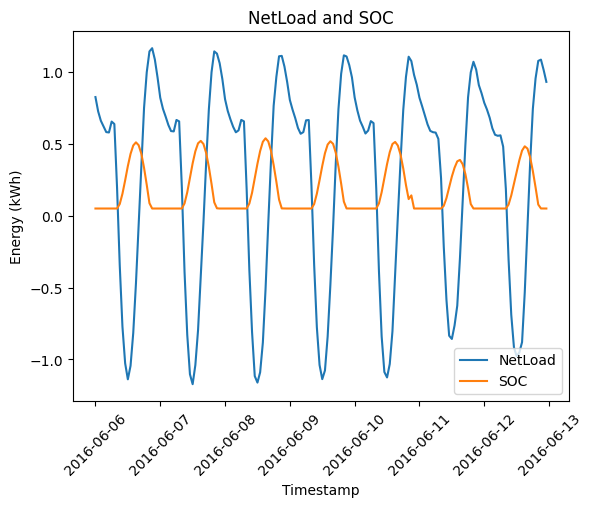

In [11]:
print(f'Optimizing for {charge_optimizer.duration} days')
charge_optimizer.local_optimize(method='SLSQP', tol=1e-4)
charge_optimizer.plot_results(week_avg.index)

## L-BFGS-B Optimization with Penalty Based Constraints

Although L-BFGS-B does not natively handle constraints, this section attempts to manually create (relatively) smooth penalties for the objective function by implementing exponential factors for either level of SOC. The main risk with placing this penalty is the distortion of the gradient outside of the constraint bound territory. However, if this could function then L-BGFS-B could be utilized for its high input efficiency – greatly improving optimization speed. 

Below you can visualize the penalty method to create an artifical constraint in the L-BFGS-B method. The sharper the exponential increase the more accurately the optimization describes realty, but the more poorly the optimization runs 

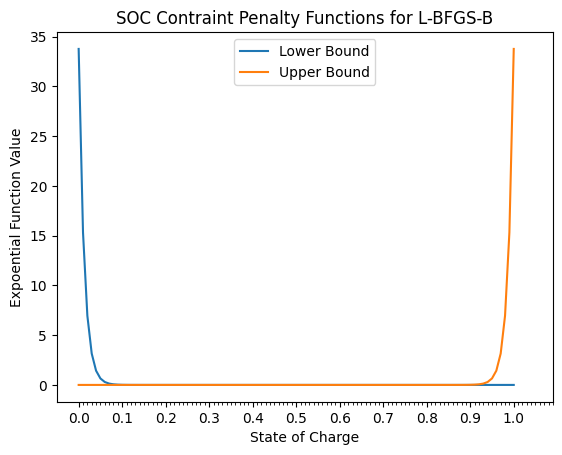

In [10]:
exp_func_params = (0.65, 79)
soc = np.arange(0, 1.01, 0.01)

soc_lb = exp_func_params[0] * np.exp(-exp_func_params[1] * (soc - 0.05))
soc_ub = exp_func_params[0] * np.exp(exp_func_params[1] * (soc - 0.95))

plt.plot(soc, soc_lb, label='Lower Bound')
plt.plot(soc, soc_ub, label='Upper Bound')
plt.xlabel('State of Charge')
plt.ylabel('Expoential Function Value')
plt.title('SOC Contraint Penalty Functions for L-BFGS-B')
plt.xticks(np.arange(0, 1.1, 0.1), minor=False)
plt.xticks(np.arange(0, 1.1, 0.01), minor=True)
plt.legend()
plt.show()

*Cutoff and Maxfun*

Below we find somewhat optimal inputs for the exp_func_params. The maxfun is currently the operation controlling the runtime of the operation. The lower maxfun is the quicker the program runs (linearly), but the worse it runs (appears to be exponential decay, but I need to look into this more)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          168     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97676D+03    |proj g|=  5.00000D-01

At iterate    1    f=  4.55954D+01    |proj g|=  9.05997D-01

At iterate    2    f=  3.58354D+01    |proj g|=  8.87971D-01

At iterate    3    f=  3.53902D+01    |proj g|=  5.13499D-01

At iterate    4    f=  3.42659D+01    |proj g|=  5.10489D-01

At iterate    5    f=  3.36300D+01    |proj g|=  5.11814D-01

At iterate    6    f=  3.31702D+01    |proj g|=  8.35846D-01

At iterate    7    f=  3.19762D+01    |proj g|=  8.75714D-01

At iterate    8    f=  3.18622D+01    |proj g|=  8.74597D-01

At iterate    9    f=  3.17012D+01    |proj g|=  8.72958D-01

At iterate   10    f=  3.14775D+01    |proj g|=  8.71166D-01

At iterate   11    f=  3.12083D+01    |proj g|=  8.68526D-01

At iterate   12    f=  3.08400D+01    |proj g|=  5.36670D-01

At iterate   13    f=  3.0

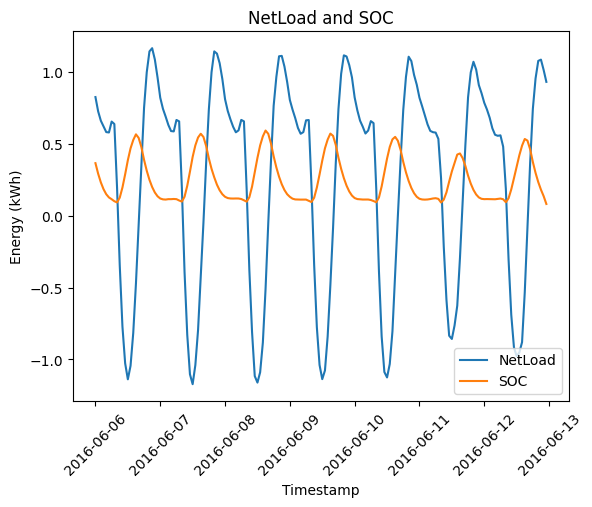

24.652360599071923

In [7]:
charge_optimizer.l_bfgs_b_optimize(exp_func_params=(0.65, 79), maxiter=3000, maxfun=10000)
charge_optimizer.plot_results(week_avg.index)
charge_optimizer.final_objective()

*Visualize outer optimization*

Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14


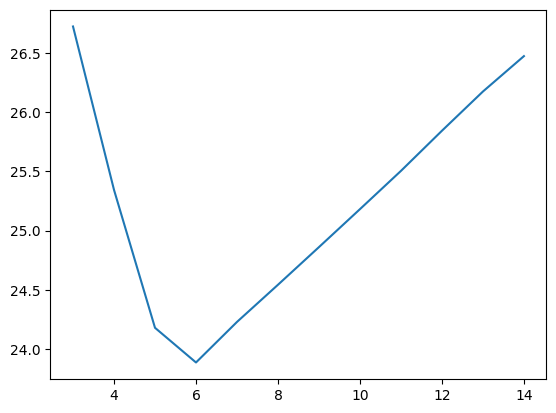

In [10]:
objective_vals = []

for i in range(3, 15):
    charge_optimizer.set_batt_capacity(i)
    charge_optimizer.l_bfgs_b_optimize(disp=False, maxiter=3000, maxfun=30000)
    objective_vals.append(float(charge_optimizer.result.fun))
    print(f'Iteration: {i}')

plt.plot(range(3, 15), objective_vals)

## Week Range Bi-Level Optimization
### L-BFGS-B as inner Optimization
Given the improved speed performance of the L-BFGS-B optimization for the charge optimization, we here attempt to use this as an efficient inner method to the bi-level optimization implemented above. 

/Users/alextseng/MacDocuments/foss-optimization/price_optimizer.py:118: RuntimeWarning: Method BFGS cannot handle bounds.
  result = spo.minimize(


Iteration of battery capacity: 2.0. Objective value: 27.80172101828686
Iteration of battery capacity: 4.0. Objective value: 25.28432970829865
Iteration of battery capacity: 3.0100000000000016. Objective value: 26.53010960628692
Iteration of battery capacity: 5.010000000000002. Objective value: 24.333874618312944
Iteration of battery capacity: 5.349144095513619. Objective value: 24.098636326393343
Iteration of battery capacity: 7.349144095513619. Objective value: 25.11783057232676
Iteration of battery capacity: 4.607705852240725. Objective value: 24.702959418117533
Iteration of battery capacity: 6.607705852240725. Objective value: 24.738911664678085
Iteration of battery capacity: 5.290597866597096. Objective value: 24.15233557201347
Iteration of battery capacity: 7.290597866597096. Objective value: 25.095826325570158
Iteration of battery capacity: 5.345388057938549. Objective value: 24.131051562824837
Iteration of battery capacity: 7.345388057938549. Objective value: 25.114871384826532


/Users/alextseng/MacDocuments/foss-optimization/.venv/lib/python3.12/site-packages/scipy/optimize/_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


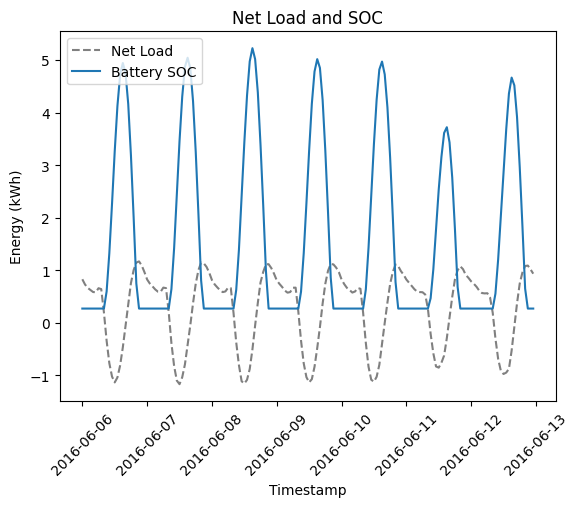

In [6]:
price_optimizer.bilevel_optimize(method='BFGS', inner_method='l_bfgs_b_optimize')
price_optimizer.plot_results(week_avg.index, False)

### SLSQP as Inner Optimization

SLSQP is naturally more accurate. There are two worlds where this is desirable: large computing resources where the accuracy justifies the extended computation. Or, if the L-BFGS-B requires such high levels of function calls (Maxfun) to create a smooth optimization plane that SLSQP and L-BFGS-B are essentially the same runtime. 

In [ ]:
price_optimizer.bilevel_optimize(method='BFGS')

# Print out info on optimimzation results
print(f'Battery Size: {price_optimizer.result.x[-1]} kWh')
print(f'Objective Function Final Value: {price_optimizer.result.fun}')
price_optimizer.plot_results(week_avg.index, False)